## Table Of Contents
 1. [Caricamento dei dati](#load)<br>
     1.1 [Grafici di esempio](#esempi)
 2. [Calcolo delle variabili di riassunto](#variabili)
 3. [Analisi esplorativa con `PCA`, `ICA`, `t-SNE`](#esplorativa)
 4. [Modello multinomiale](#multinomiale)<br>
     4.1 [Modello multinomiale penalizzato](#multinomiale-pen)
 5. [Analisi discriminante](#lda-qda)<br>
     5.1 [Analisi discriminante penalizzata](#da-pen)
 6. [Alberi di regressione](#tree)<br>
     6.1 [Alberi di regressione penalizzati](#tree-penalized)<br>

END. [Salvataggio dei dati](#save)

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
# Funzioni base:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import os
import seaborn as sns
import tqdm

# Font di LaTeX
# from matplotlib import rc

# Scikit-Learn
from sklearn.model_selection import train_test_split, ParameterGrid
from sklearn.decomposition import PCA, FastICA
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
from sklearn.manifold import TSNE
from sklearn.metrics import accuracy_score, confusion_matrix
from sklearn.dummy import DummyClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, export_graphviz
import graphviz
# Funzioni custom
from funzioni import AbsMeanVarDeriv, Whiten,ScatterGroup, MatriceConfusione, indice_gini
from funzioni import tasso_errata_classificazione, grafico_metrica_iperparametro, grafico_metrica_iperparametri
from funzioni.grafici import grafico_importanza_variabili

# 1. Caricamento dei dati <a id=load> </a>

In [3]:
PATH_DATA = './PhonePi/data/'
FIG_PATH = './figure/'
DIR = [os.path.join(PATH_DATA, o) for o in os.listdir(PATH_DATA) 
                    if os.path.isdir(os.path.join(PATH_DATA,o))]
tipo=[(dir.split("/")[-1]).split(".")[0] for dir in DIR]
tipo=[dir.split("-")[0] for dir in tipo]

In [4]:
p = 150 # numero osservazioni per intervallo
nomi_colonna=["user","azione"]
nomi_colonna.extend(["a"+str(i) for i in range(p)])
nomi_colonna
X=pd.DataFrame(columns=nomi_colonna)

for i in tqdm.tqdm(range(len(DIR))):
    data = pd.read_csv(DIR[i] + "/accelerometer.txt", names = ["user", "type", "t", "ax", "ay", "az"]) # lettura dati
    data["t"] = data["t"] - data["t"].iloc[0] # t0 = 0
    data = data[(data["t"] > 7000) & (data["t"] < (data["t"].max()-7000))] # tolti i primi e ultimi 7 secondi
    data.reset_index(drop=True, inplace=True) # ripristinati gli indici da 0 in avanti
    data["a"] = (pd.to_numeric(data["ax"])**2 + pd.to_numeric(data["ay"])**2 + pd.to_numeric(data["az"])**2)**0.5 # accelerazione in modulo
    nome = [data.user[j] for j in range(0,len(data)-p, p)] # intervalli di dt*100ms
    tipologia=[tipo[i]]*len(nome)
    righe=[[nome[j],tipologia[j]] for j in range(len(nome))]
    [righe[j].extend(list(data.a[j*p:(j+1)*p])) for j in range(len(nome))]
    X=pd.concat([X,pd.DataFrame(righe,columns=nomi_colonna)],ignore_index=True) # ignore_index=T per avere indici consecutivi

100%|██████████████████████████████████████████| 44/44 [00:05<00:00,  8.21it/s]


## 1.1 Grafici di esempio <a id=esempi> </a>

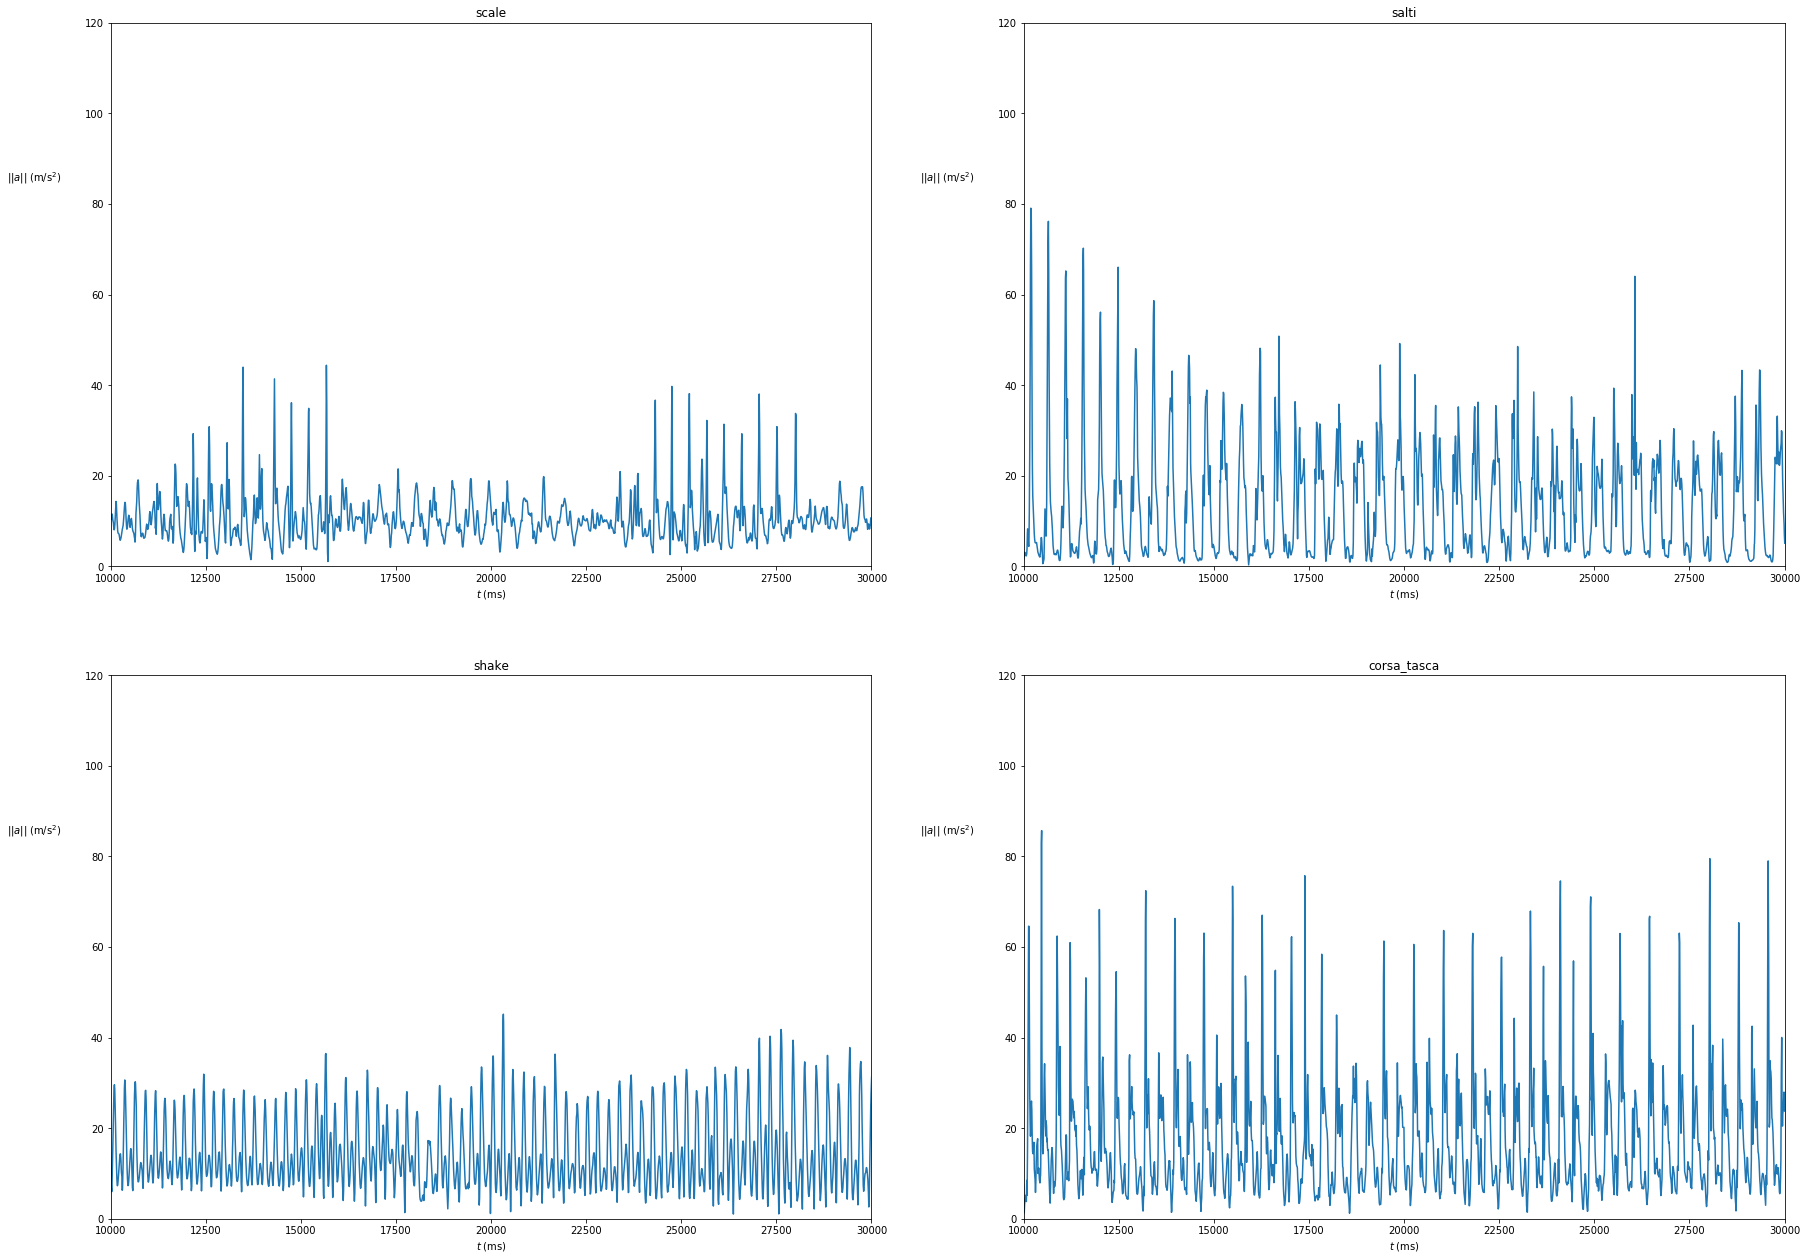

In [5]:
DIRM = ['./PhonePi/data/scale-martina',
        './PhonePi/data/salti-daniele',
        './PhonePi/data/shake-anna',
        './PhonePi/data/corsa_tasca-alberto'
       ]
loc = [1,2,3,4]
plt.figure(figsize=(7.5*len(DIRM),5.5*len(DIRM)))
for i in range(4):
    data = pd.read_csv(DIRM[i] + "/accelerometer.txt", names = ["user", "type", "t", "ax", "ay", "az"])
    data["t"] = data["t"] - data["t"].iloc[0]
    data = data[(data["t"] > 7000) & (data["t"] < (data["t"].max()-7000))]
    data["a"] = (pd.to_numeric(data["ax"])**2 + pd.to_numeric(data["ay"])**2 + pd.to_numeric(data["az"])**2)**0.5 # accelerazione in modulo
    ax = plt.subplot(2, 2, i+1 , ylim=(0,120), xlim = (10000,30000))
    ax.set_ylabel(r"$\|\|a\|\|\;(\mathrm{ m/s}^2)$", rotation=0)
    ax.yaxis.set_label_coords(-0.1,0.7)
    ax.set_xlabel(r"$t \;(\mathrm{ ms})$")
    ax.set_title((DIRM[i].split("/")[-1]).split("-")[0])
    plt.plot(data["t"],data["a"])
    plt.savefig(FIG_PATH+"espl.png", dpi=150)
plt.show()

# 2. Calcolo delle variabili di riassunto <a id=variabili> </a>

In [6]:
y = X.azione
X.drop("azione", axis=1, inplace=True)
Xnum = X.drop("user", axis=1)

In [7]:
maxA = Xnum.max(1) # massimo accelerazione
MVDeriv = AbsMeanVarDeriv(Xnum, 10) # variazione media della derivata
meanA = Xnum.mean(axis=1)
varA = Xnum.var(axis=1)
medA = Xnum.median(axis=1)
minA = Xnum.min(axis=1)

In [8]:
espl = pd.concat([maxA, MVDeriv, meanA, varA, medA, minA], axis=1)
espl.columns=["maxA", "MVDeriv", "meanA", "varA", "medA", "minA"]

In [9]:
X.to_pickle("X-2s.pkl")
y.to_pickle("y-2s.pkl")
espl.to_pickle("espl.pkl")

In [45]:
#per luisa
X.to_csv("X-2s.csv")
y.to_csv("y-2s.csv")
espl.to_csv("espl.csv")

In [10]:
X_train, X_val, y_train, y_val = train_test_split(espl, y, test_size=0.25, random_state=42)

# 3. Analisi esplorativa con `PCA`, `ICA`, `t-SNE` <a id=esplorativa> </a>

In [11]:
# Sbiancamento dei dati
esplWh = Whiten().fit_transform(espl)

pca = PCA(n_components=2, random_state=42)
esplPCA = pca.fit_transform(esplWh)

ica = FastICA(n_components=2, random_state=42)
esplICA = ica.fit_transform(esplWh)

tsne = TSNE(n_components=2, random_state=42)
esplTSNE = tsne.fit_transform(esplWh)

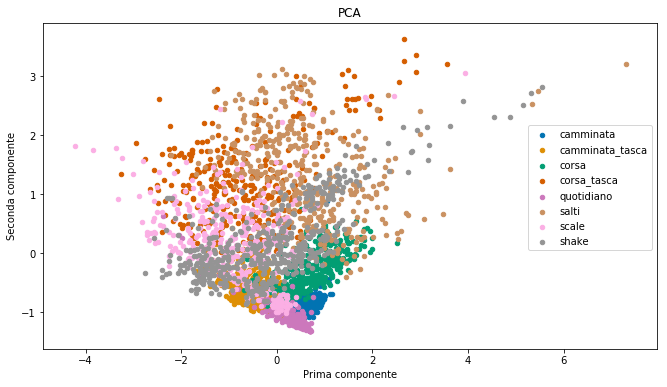

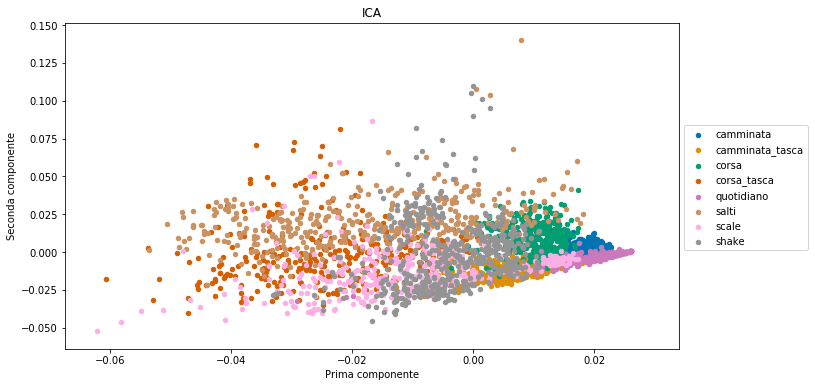

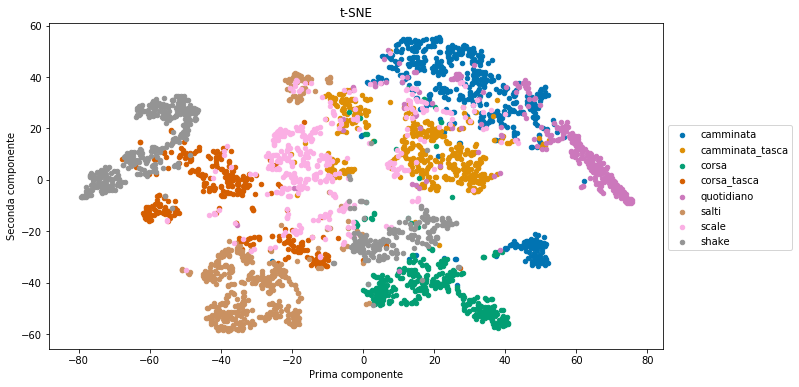

In [12]:
for title,dat in zip(["PCA","ICA","t-SNE"], [esplPCA, esplICA, esplTSNE]):
    fig, ax = ScatterGroup(pd.DataFrame(dat, columns=["Prima componente", "Seconda componente"]),
                       grp=y, palette="colorblind")
    fig.set_figwidth(11)
    fig.set_figheight(6)
    ax.set_title(title)
    plt.legend(bbox_to_anchor=(1,0.7))
    plt.savefig(FIG_PATH+title+".png", bbox_inches="tight", dpi=180)

# 4. Modello multinomiale <a id=multinomiale> </a>

C:\Users\admin\Anaconda3\envs\msbd\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


Regressione multinomiale: 87.2% di accuratezza


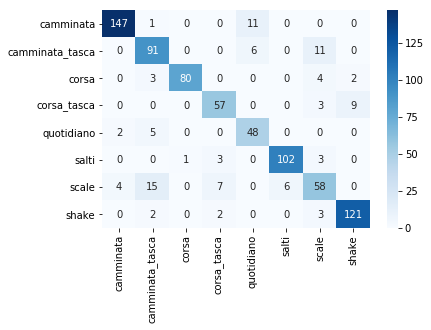

<Figure size 432x288 with 0 Axes>

In [13]:
glmMult = LogisticRegression(penalty="l2", C=float("inf"), random_state=42, multi_class="multinomial",
                             solver="newton-cg", max_iter=300)
fit = glmMult.fit(X_train, y_train)
y_pred = fit.predict(X_val)

acc_mn = 100*accuracy_score(y_val, y_pred)
print("Regressione multinomiale: {:.1f}% di accuratezza".format(acc_mn))
MatriceConfusione(y_val, y_pred)
plt.savefig(FIG_PATH+"confusionMatrix-Mn.png", dpi=300, bbox_inches="tight")

## 4.1 Modello multinomiale penalizzato <a id=multinomiale-pen></a>

In [14]:
fit.classes_

array(['camminata', 'camminata_tasca', 'corsa', 'corsa_tasca',
       'quotidiano', 'salti', 'scale', 'shake'], dtype=object)

In [15]:
i = 11.5
weights = y_train.value_counts()/y_train.value_counts().sum()
weights["shake"]/=i
weights/=weights.sum()
w = {ind:weights[ind] for ind in weights.index}

C:\Users\admin\Anaconda3\envs\msbd\lib\site-packages\sklearn\utils\optimize.py:203: ConvergenceWarning: newton-cg failed to converge. Increase the number of iterations.
  "number of iterations.", ConvergenceWarning)


Regressione multinomiale penalizzata: 84.5% di accuratezza


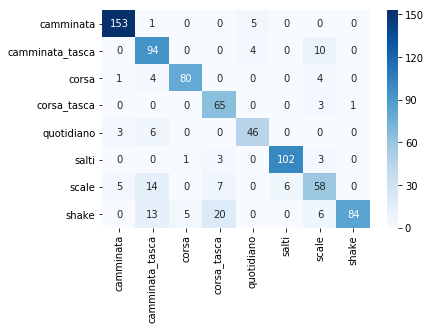

<Figure size 432x288 with 0 Axes>

In [16]:
glmMult = LogisticRegression(penalty="l2", C=float("inf"), random_state=42, multi_class="multinomial",
                             solver="newton-cg", max_iter=300, class_weight=w)
fit = glmMult.fit(X_train, y_train)
y_pred = fit.predict(X_val)

acc_mn_pen = 100*accuracy_score(y_val, y_pred)
print("Regressione multinomiale penalizzata: {:.1f}% di accuratezza".format(acc_mn_pen))
MatriceConfusione(y_val, y_pred)
plt.savefig(FIG_PATH+"confusionMatrix-Mn-penalizzata.png", dpi=300, bbox_inches="tight")

In [17]:
# TODO: grid search per il miglior peso nella multinomiale.

# 5. Analisi discriminante lineare e quadratica <a id=lda-qda> </a>

Accuratezza LDA: 79.2%


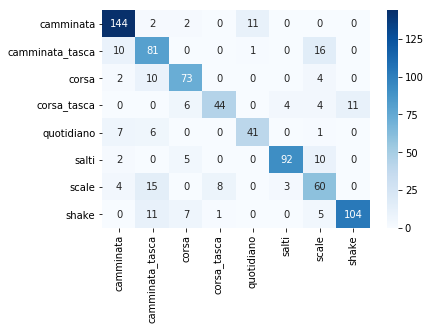

In [18]:
lda = LinearDiscriminantAnalysis()
X_lda=lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_val)
acc_lda = 100*accuracy_score(y_val, y_pred_lda)
print("Accuratezza LDA: {:.1f}%".format(acc_lda))
MatriceConfusione(y_val, y_pred_lda,nome_immagine=FIG_PATH+"confusionMatrix-LDA")

Accuratezza QDA: 88.2%


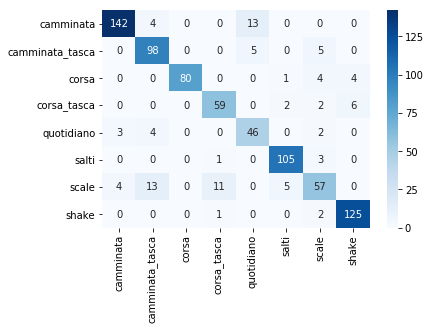

In [19]:
qda = QuadraticDiscriminantAnalysis()
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_val)
acc_qda = 100*accuracy_score(y_val, y_pred_qda)
print("Accuratezza QDA: {:.1f}%".format(acc_qda))
MatriceConfusione(y_val, y_pred_qda,nome_immagine=FIG_PATH+"confusionMatrix-QDA")

## 5.1 Analisi discriminante penalizzata <a id=da-pen> </a>

In [20]:
print(lda.classes_)

['camminata' 'camminata_tasca' 'corsa' 'corsa_tasca' 'quotidiano' 'salti'
 'scale' 'shake']


In [21]:
lab = y.unique()
lab.sort()
print(lab)

['camminata' 'camminata_tasca' 'corsa' 'corsa_tasca' 'quotidiano' 'salti'
 'scale' 'shake']


### LDA penalizzata

In [22]:
lista_acc_lda=[]
lista_veri_positivi_lda=[]
lista_numero_sbagliati_lda=[]
w_lda=[]
for i in np.arange(1.1,12,0.1):
    weights = np.array(y_train.value_counts()/y_train.value_counts().sum())
    weights[-1] /= i
    weights = weights/weights.sum()
    w_lda.append(weights[-1])
    lda = LinearDiscriminantAnalysis(priors=weights)
    X_lda=lda.fit(X_train, y_train)
    y_pred_lda = lda.predict(X_val)
    lista_acc_lda.append(100*accuracy_score(y_val, y_pred_lda))
    lista_veri_positivi_lda.append(100*(confusion_matrix(y_val, y_pred_lda, labels=lab)[-1,-1]/confusion_matrix(y_val, y_pred_lda,labels=lab)[:,-1].sum()))
    lista_numero_sbagliati_lda.append(confusion_matrix(y_val, y_pred_lda,labels=lab)[:-1,-1].sum())

### LDA penalizzata

In [23]:
lista_acc_qda=[]
lista_veri_positivi_qda=[]
lista_numero_sbagliati_qda=[]
w_qda=[]
for i in np.arange(1.1,12,0.1):     #qda ne sbaglia sempre uno anche con pesi molto elevati
    weights = np.array(y_train.value_counts()/y_train.value_counts().sum())
    weights[-1] /= i
    weights = weights/weights.sum()
    w_qda.append(weights[-1])
    qda = QuadraticDiscriminantAnalysis(priors=weights)
    qda.fit(X_train, y_train)
    y_pred_qda = qda.predict(X_val)
    lista_acc_qda.append(100*accuracy_score(y_val, y_pred_qda))
    lista_veri_positivi_qda.append(100*(confusion_matrix(y_val, y_pred_qda,labels=lab)[-1,-1]/confusion_matrix(y_val, y_pred_qda,labels=lab)[:,-1].sum()))
    lista_numero_sbagliati_qda.append(confusion_matrix(y_val, y_pred_qda,labels=lab)[:-1,-1].sum())

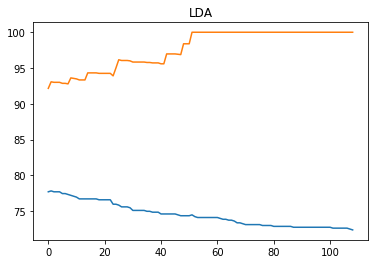

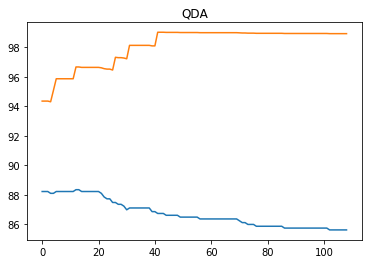

In [24]:
# in pratica per pesi crescenti assegnati alla classe dello shake si nota che la percentuale di veri positivi aumenta
# e l'accuratezza ovviamente diminuisce. Se vogliamo che l'errore di classificare shake qualcosa che non è shake sia nullo
# (o <0.01) scegliamo il primo peso che mi porta ad avere veri_positivi uguale a 100 (o 99) in modo da scegliere 
# il modello con l'accuratezza migliore fra quelli che non sbagliano lo shake

plt.plot(lista_acc_lda)
plt.plot(lista_veri_positivi_lda)
#plt.plot(lista_numero_sbagliati_lda)
plt.title("LDA")
plt.show()

plt.plot(lista_acc_qda)
plt.plot(lista_veri_positivi_qda)
#plt.plot(lista_numero_sbagliati_qda)
plt.title("QDA")
plt.show()

In [25]:
lista_veri_positivi_qda[-1]

98.9247311827957

In [26]:
lista_veri_positivi_lda=np.array(lista_veri_positivi_lda)
num_iterazione_lda=np.min(np.where(lista_veri_positivi_lda>99))
peso_shake_lda=np.arange(1.1,12,0.1)[num_iterazione_lda]
peso_shake_lda

6.200000000000005

In [27]:
lista_veri_positivi_qda=np.array(lista_veri_positivi_qda)
num_iterazione_qda=np.min(np.where(lista_veri_positivi_qda>98))
peso_shake_qda=np.arange(1.1,12,0.1)[num_iterazione_qda]
peso_shake_qda

4.200000000000003

Accuratezza LDA: 74.5%


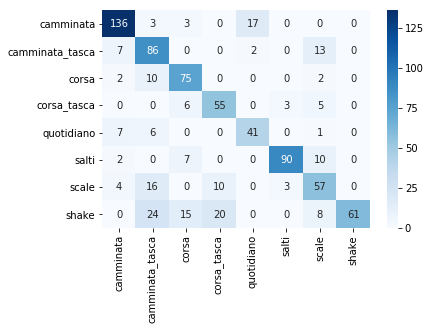

In [28]:
weights = np.array(y_train.value_counts()/y_train.value_counts().sum())
weights[-1] /= peso_shake_lda
weights = weights/weights.sum()
lda = LinearDiscriminantAnalysis(priors=weights)
X_lda=lda.fit(X_train, y_train)
y_pred_lda = lda.predict(X_val)
acc_lda = 100*accuracy_score(y_val, y_pred_lda)
print("Accuratezza LDA: {:.1f}%".format(acc_lda))
MatriceConfusione(y_val, y_pred_lda,nome_immagine=FIG_PATH+"confusionMatrix-LDA-penalizzata")

Accuratezza QDA: 87.1%


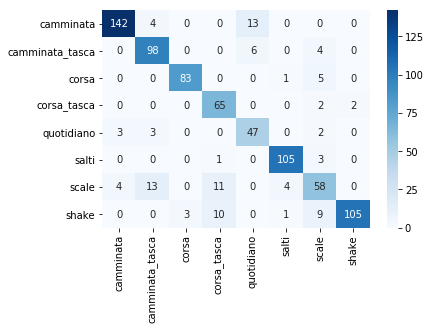

In [29]:
weights = np.array(y_train.value_counts()/y_train.value_counts().sum())
weights[-1] /= peso_shake_qda
weights = weights/weights.sum()
qda = QuadraticDiscriminantAnalysis(priors=weights)
qda.fit(X_train, y_train)
y_pred_qda = qda.predict(X_val)
acc_qda = 100*accuracy_score(y_val, y_pred_qda)
print("Accuratezza QDA: {:.1f}%".format(acc_qda))
MatriceConfusione(y_val, y_pred_qda,nome_immagine=FIG_PATH+"confusionMatrix-QDA-penalizzata")

# 6. Alberi di regressione <a id=tree> </a>

Accuratezza DecisionTreeClassifier(): 85.38%


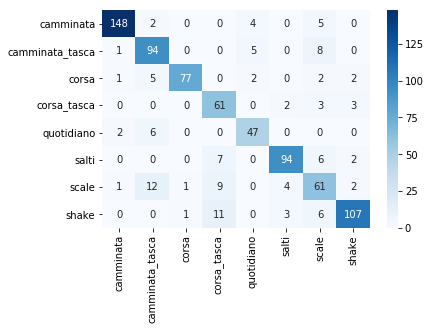

In [30]:
# Albero stimato sul training, senza vincoli (albero completo)
dtc = DecisionTreeClassifier(random_state=42)
dtc.fit(X_train, y_train)
y_pred = dtc.predict(X_val)
acc_dtcFull = 100*accuracy_score(y_val, y_pred)

print("Accuratezza DecisionTreeClassifier(): {:.2f}%".format(acc_dtcFull))
MatriceConfusione(y_val, y_pred)
plt.show()

In [31]:
maxDepth = dtc.tree_.max_depth
minObs = len(X_train) // 2
print("Profondità dell'albero allenato senza restrizioni: {}".format(maxDepth))
print("Massimo numero minimo di osservazioni in una foglia: {}".format(minObs))

Profondità dell'albero allenato senza restrizioni: 21
Massimo numero minimo di osservazioni in una foglia: 1209


In [32]:
param_grid = ParameterGrid({
    'max_depth': np.arange(1, dtc.tree_.max_depth+1),
    'min_samples_leaf': 2 ** np.arange(int(np.log2(minObs) + 1)),
})
print(param_grid.param_grid)

[{'max_depth': array([ 1,  2,  3,  4,  5,  6,  7,  8,  9, 10, 11, 12, 13, 14, 15, 16, 17,
       18, 19, 20, 21]), 'min_samples_leaf': array([   1,    2,    4,    8,   16,   32,   64,  128,  256,  512, 1024],
      dtype=int32)}]


In [33]:
risultati = []

for params in tqdm.tqdm(param_grid):
    dtc = DecisionTreeClassifier(random_state=42, **params)
    dtc.fit(X_train, y_train)
    y_pred = dtc.predict(X_val)
    params["accuracy_score"] = accuracy_score(y_val, y_pred)
    risultati.append(params)

risultati = pd.DataFrame(risultati).sort_values(["accuracy_score", "max_depth"], ascending=[False, True])
risultati.reset_index(drop=True, inplace=True)
print("Primi 5:")
display(risultati.head())

print("Ultimi 5:")
risultati.tail()

100%|████████████████████████████████████████| 231/231 [00:03<00:00, 61.38it/s]


Primi 5:


,accuracy_score,max_depth,min_samples_leaf
0,0.867410,15,2
1,0.866171,16,4
2,0.866171,17,4
3,0.863693,12,2
4,0.863693,12,4


Ultimi 5:


,accuracy_score,max_depth,min_samples_leaf
226,0.337051,17,1024
227,0.337051,18,1024
228,0.337051,19,1024
229,0.337051,20,1024
230,0.337051,21,1024


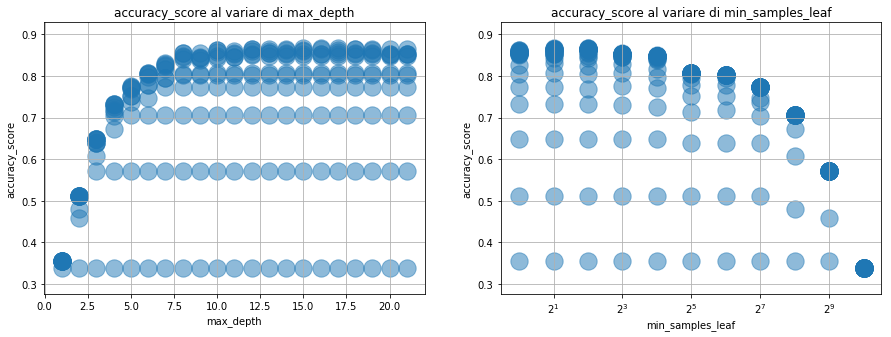

In [34]:
plt.figure(figsize=(15, 5))

plt.subplot(121)
grafico_metrica_iperparametro(risultati, "max_depth", "accuracy_score", alpha=0.5)

plt.subplot(122)
grafico_metrica_iperparametro(risultati, "min_samples_leaf", "accuracy_score", alpha=0.5)
plt.xscale("log", basex=2)

plt.show()

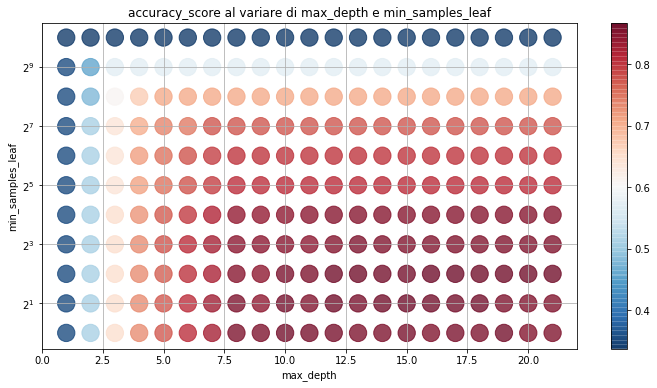

In [35]:
plt.figure(figsize=(12, 6))

grafico_metrica_iperparametri(risultati, "max_depth", "min_samples_leaf", "accuracy_score")
plt.yscale("log", basey=2)
plt.savefig(FIG_PATH + "iperparametri-Tree.png", dpi=200)
plt.show()

In [36]:
max_depth = risultati.loc[0, "max_depth"]
min_samples_leaf = risultati.loc[0, "min_samples_leaf"]

dtcTun = DecisionTreeClassifier(max_depth=max_depth, min_samples_leaf=min_samples_leaf, random_state=42)
dtcTun.fit(X_train, y_train)

y_pred = dtcTun.predict(X_val)
acc_dtcTun = 100*accuracy_score(y_val, y_pred)
print("profondità ottimale:",max_depth)
print("numero ottimale minimo di unità per foglia:",min_samples_leaf)

profondità ottimale: 15
numero ottimale minimo di unità per foglia: 2


Accuratezza DecisionTreeClassifier(): 85.4%
Accuratezza DecisionTreeClassifier(max_depth=15, min_samples_leaf=2): 86.7%
[[154   1   0   0   2   0   2   0]
 [  1 100   0   0   4   0   3   0]
 [  4   4  77   0   0   0   1   3]
 [  0   0   0  59   0   3   5   2]
 [  4   6   0   0  45   0   0   0]
 [  0   0   0   7   0  95   7   0]
 [  1  11   2  11   0   3  60   2]
 [  0   0   2  11   0   1   4 110]]


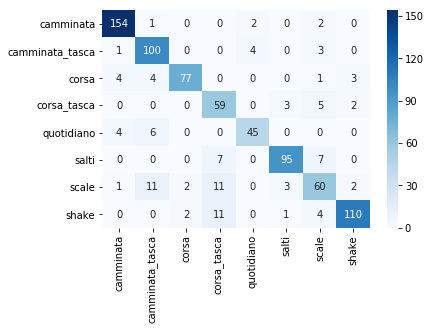

<Figure size 432x288 with 0 Axes>

In [37]:
print("Accuratezza DecisionTreeClassifier(): {:.1f}%".format(acc_dtcFull))
print("Accuratezza DecisionTreeClassifier(max_depth={}, min_samples_leaf={}): {:.1f}%".format(
    max_depth, min_samples_leaf, acc_dtcTun))
print(confusion_matrix(y_val, y_pred))

MatriceConfusione(y_val, y_pred)
plt.savefig(FIG_PATH + "confusionMatrix-Tree.png", dpi=300, bbox_inches="tight")
plt.show()

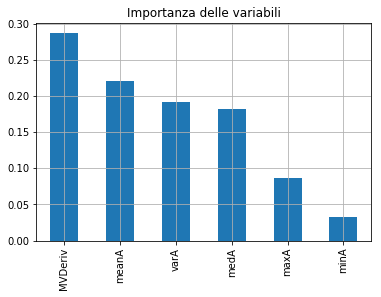

In [38]:
importanze = dtcTun.feature_importances_
variabili = espl.columns

grafico_importanza_variabili(importanze, variabili)
plt.savefig(FIG_PATH + "importance-Tree.png", dpi=300, bbox_inches="tight")
plt.show()

## 6.1 Alberi di regressione penalizzati  <a id=tree-penalized> </a>

In [39]:
dtc.classes_

array(['camminata', 'camminata_tasca', 'corsa', 'corsa_tasca',
       'quotidiano', 'salti', 'scale', 'shake'], dtype=object)

# END. Salvataggio dei risultati <a id=save> </a>

## Tabella accuracy in file LaTeX

In [40]:
tableEnvBegin = "\\begin{table}[H]\n\\centering"
tableEnvEnd = "\end{table}"

In [41]:
accuracy = pd.DataFrame([["Multinomiale", acc_mn],
             ["LDA", acc_lda],
             ["QDA", acc_qda],
             ["Decision Tree", acc_dtcFull],
             ["Pruned Decision Tree", acc_dtcTun]], columns=["Modello", "Accuracy %"])

accuracy.sort_values("Accuracy %", inplace=True)
caption='\\caption{Accuratezza per i modelli adattati.}\n'

In [42]:
with open("./relazione/tex/accuracy-table.tex", mode="w") as file:
    file.write(tableEnvBegin + caption + accuracy.to_latex(index=False, float_format="%.2f", column_format="cc") + tableEnvEnd)

In [43]:
# TODO: tabella accuracy - falsi positivi shake

### Crop delle immagini

In [44]:
import platform
if platform.system() == "Linux":
    !mogrify -trim ./figure/*.png